In [1]:
import pandas as pd

In [2]:
import torch
torch.cuda.is_available()

False

In [2]:
import scanpy as sc

In [3]:
!pwd

/mmfs1/home/mmigl/mm_notebooks/single_cell


In [59]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Integrated.ipynb
	modified:   Scanpy_Sample1_final.ipynb
	modified:   Scanpy_Sample2_final.ipynb
	modified:   Scanpy_Sample3_final.ipynb
	modified:   Scanpy_Sample4_final.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/

no changes added to commit (use "git add" and/or "git commit -a")


In [9]:
import os

In [13]:
os.chdir('/mmfs1/home/mmigl/mm_notebooks/single_cell')

In [14]:
!pwd

/mmfs1/home/mmigl/mm_notebooks/single_cell


In [4]:
sc.settings.verbosity = 3  
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-06-09 00:04:19.332272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 00:04:20.766225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [6]:
adata_1 = sc.read_10x_h5(
    "/home/mmigl/cellbender/output/sample1_filtered_filtered.h5"
)

reading /home/mmigl/cellbender/output/sample1_filtered_filtered.h5
 (0:00:00)


In [7]:
adata_1

AnnData object with n_obs × n_vars = 7114 × 37143
    var: 'gene_ids', 'feature_types', 'genome'

In [161]:
#Pre-processing for improving the quality of the data before analysis

In [8]:
adata_1.var_names_make_unique()
sc.pp.filter_cells(adata_1, min_genes=200) 
sc.pp.filter_genes(adata_1, min_cells=3) 

filtered out 1343 cells that have less than 200 genes expressed
filtered out 20648 genes that are detected in less than 3 cells


In [9]:
adata_1

AnnData object with n_obs × n_vars = 5771 × 16495
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [190]:
#Doublet Removal

In [23]:
#pip install --user scikit-misc

In [10]:
doublet_1 = adata_1.copy()

In [11]:
sc.pp.highly_variable_genes(doublet_1, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [4]:
import scvi

In [13]:
scvi.model.SCVI.setup_anndata(doublet_1)
vae = scvi.model.SCVI(doublet_1)
vae.train()

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [02:22<00:00,  2.84it/s, v_num=1, train_loss_step=388, train_loss_epoch=444]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [02:22<00:00,  2.81it/s, v_num=1, train_loss_step=388, train_loss_epoch=444]


In [14]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 293/400:  73%|████████████▍    | 293/400 [01:44<00:38,  2.81it/s, v_num=1, train_loss_step=0.33, train_loss_epoch=0.418]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.420. Signaling Trainer to stop.


In [15]:
doublet = solo.predict()
doublet['prediction'] = solo.predict(soft = False)

In [16]:
doublet.groupby('prediction').count()

doublet  singlet
prediction                  
doublet        2481     2481
singlet        3290     3290

In [17]:
doublet['difference'] = doublet.doublet - doublet.singlet
doublet

doublet   singlet prediction  difference
CCCATAGGTTTCAGGTACTTTAGG-1  0.902542 -2.177081    doublet    3.079623
TATTGGGCATCTATGCACTTTAGG-1  0.107572 -1.140175    doublet    1.247747
GTTCCATCACGGATACACTTTAGG-1  0.690342 -2.250731    doublet    2.941073
CTAGGTACAAGCCACGACTTTAGG-1  1.464616 -1.939306    doublet    3.403922
CTCGATCAGCGAATCGACTTTAGG-1  0.930928 -1.850166    doublet    2.781094
...                              ...       ...        ...         ...
TGTGCGCGTCATGAAGACTTTAGG-1 -1.210391  1.325261    singlet   -2.535652
ACTAATGAGATAGCTAACTTTAGG-1 -1.707193  1.968038    singlet   -3.675232
GTCAGTGAGCATGTGGACTTTAGG-1 -1.787104  1.778507    singlet   -3.565611
CAACCAACAGCCAGCAACTTTAGG-1 -2.299892  2.750622    singlet   -5.050515
AAGTTGCAGCGCTACTACTTTAGG-1 -2.201109  2.261795    singlet   -4.462904

[5771 rows x 4 columns]

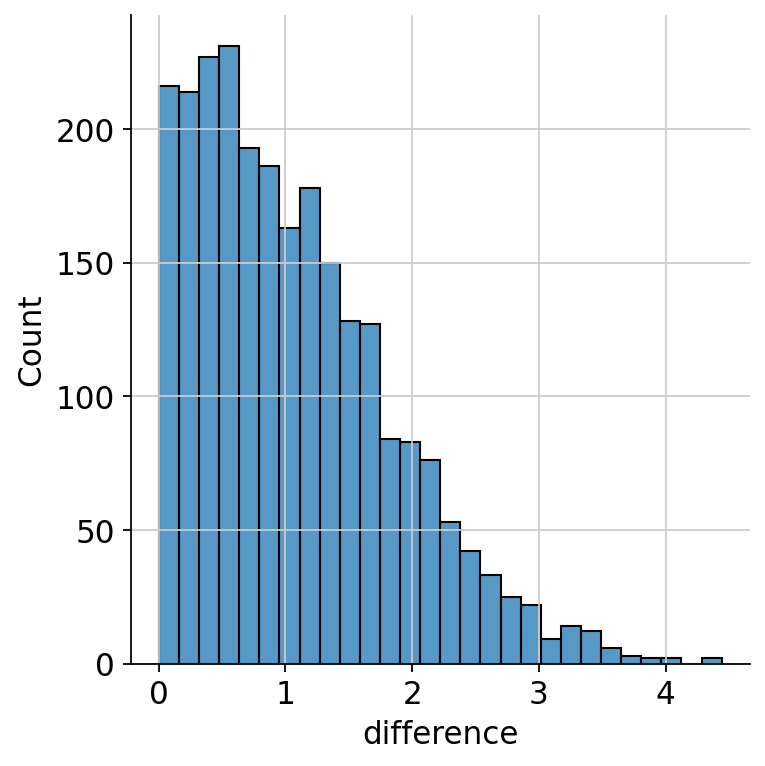

In [18]:
import seaborn as sns
sns.displot(doublet[doublet.prediction == 'doublet'], x = 'difference')

In [19]:
doublet = doublet[(doublet['prediction'] == 'doublet') & (doublet['difference'] > 1)]
doublet

doublet   singlet prediction  difference
CCCATAGGTTTCAGGTACTTTAGG-1  0.902542 -2.177081    doublet    3.079623
TATTGGGCATCTATGCACTTTAGG-1  0.107572 -1.140175    doublet    1.247747
GTTCCATCACGGATACACTTTAGG-1  0.690342 -2.250731    doublet    2.941073
CTAGGTACAAGCCACGACTTTAGG-1  1.464616 -1.939306    doublet    3.403922
CTCGATCAGCGAATCGACTTTAGG-1  0.930928 -1.850166    doublet    2.781094
...                              ...       ...        ...         ...
CTTGCTGCAGGATCCGACTTTAGG-1  0.931391 -0.487061    doublet    1.418452
TGAACCTGTACACCCAACTTTAGG-1  0.532167 -0.700962    doublet    1.233129
GCTTAGGAGTGAATCAACTTTAGG-1  1.620414 -1.284826    doublet    2.905240
ATGACTTTCGATTACTACTTTAGG-1  0.968798 -0.150515    doublet    1.119313
CGTGTCCCACCGTTTGACTTTAGG-1  0.941863 -0.488710    doublet    1.430574

[1170 rows x 4 columns]

In [20]:
adata_1.obs['doublet'] = adata_1.obs.index.isin(doublet.index)

In [21]:
adata_1 = adata_1[~adata_1.obs.doublet]

In [23]:
adata_1.var["mt"] = adata_1.var_names.str.startswith("MT-")

In [24]:
sc.pp.calculate_qc_metrics(adata_1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

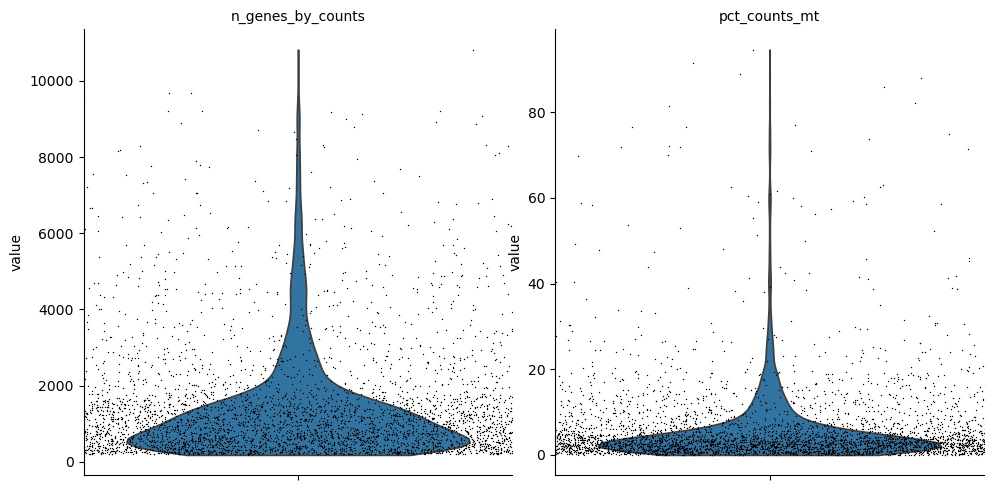

In [6]:
sc.pl.violin(adata_1, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

In [7]:
import numpy as np

In [8]:
def pp(adata):
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.write('adata_1_filtered_new.h5ad', adata)
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.normalize_total(adata) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata 
    adata = adata[:, adata.var.highly_variable] 
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) 
    sc.pp.scale(adata, max_value=10) 
    sc.tl.pca(adata, svd_solver='arpack')
    sc.write('adata_1_pca_new.h5ad', adata)
    return adata

In [9]:
adata_1 = pp(adata_1)

/tmp/ipykernel_9437/780063713.py:6: ImplicitModificationWarning: Setting element `.layers['Counts']` of view, initializing view as actual.
  adata.layers['Counts'] = adata.X.copy()
/home/mmigl/.conda/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
adata_1 = sc.read('/home/mmigl/dom_ameen_chi_link/mmigl/notebooks/adata_1_pca_new.h5ad')

In [5]:
adata_1

AnnData object with n_obs × n_vars = 4291 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Counts'

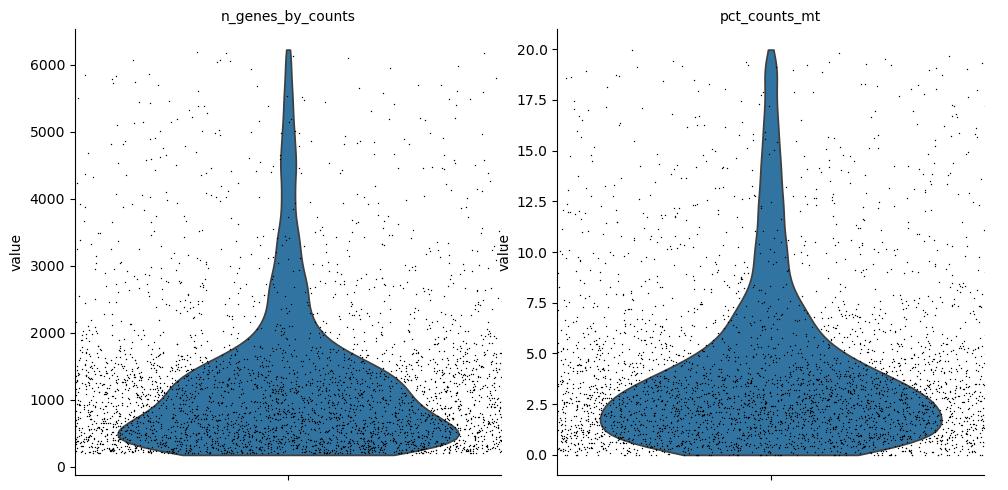

In [6]:
sc.pl.violin(adata_1, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

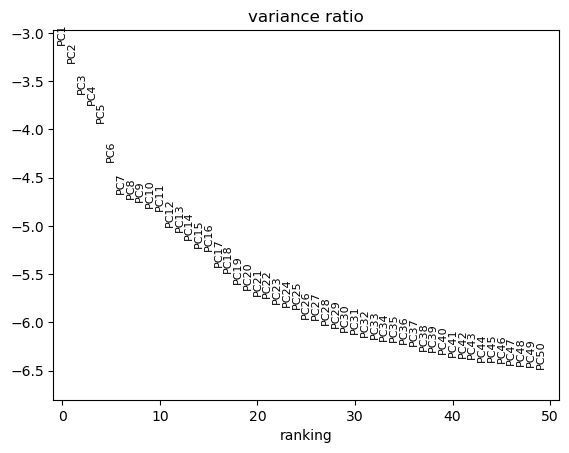

In [7]:
sc.pl.pca_variance_ratio(adata_1, log=True, n_pcs=50)

In [8]:
sc.pp.neighbors(adata_1, n_pcs=40)
sc.tl.umap(adata_1)
sc.tl.leiden(adata_1, resolution = 0.5)
sc.tl.rank_genes_groups(adata_1, "leiden", method="wilcoxon")
sc.write('adata_1_de_new.h5ad', adata_1)

2024-06-09 10:36:00.670399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 10:36:02.129197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_17620/2783810040.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_1, resolution = 0.5)


In [4]:
adata_1 = sc.read("/home/mmigl/dom_ameen_chi_link/mmigl/notebooks/adata_1_de_new.h5ad")

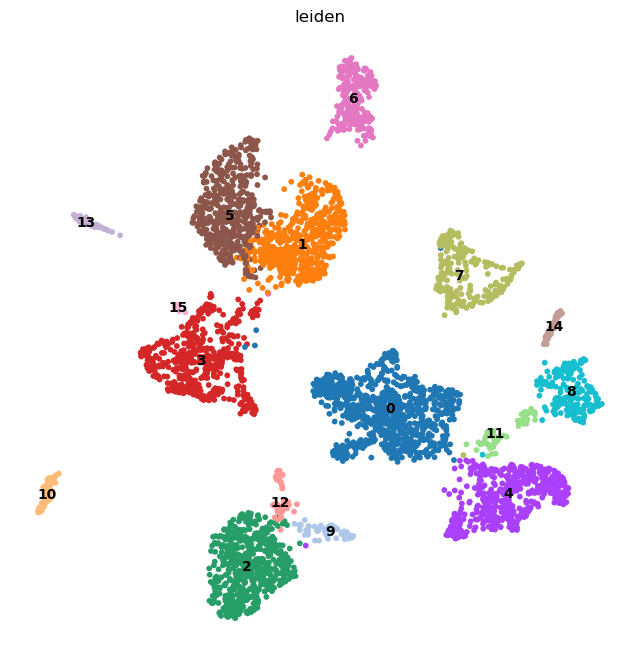

In [5]:
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_1, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

In [6]:
n_markers = ['S100A12', 'SPP1', 'VEGFA', 'CXCL8', 'IL1B', 'CXCR2', 'IFIT1', 'ISG15', 'MMP9']

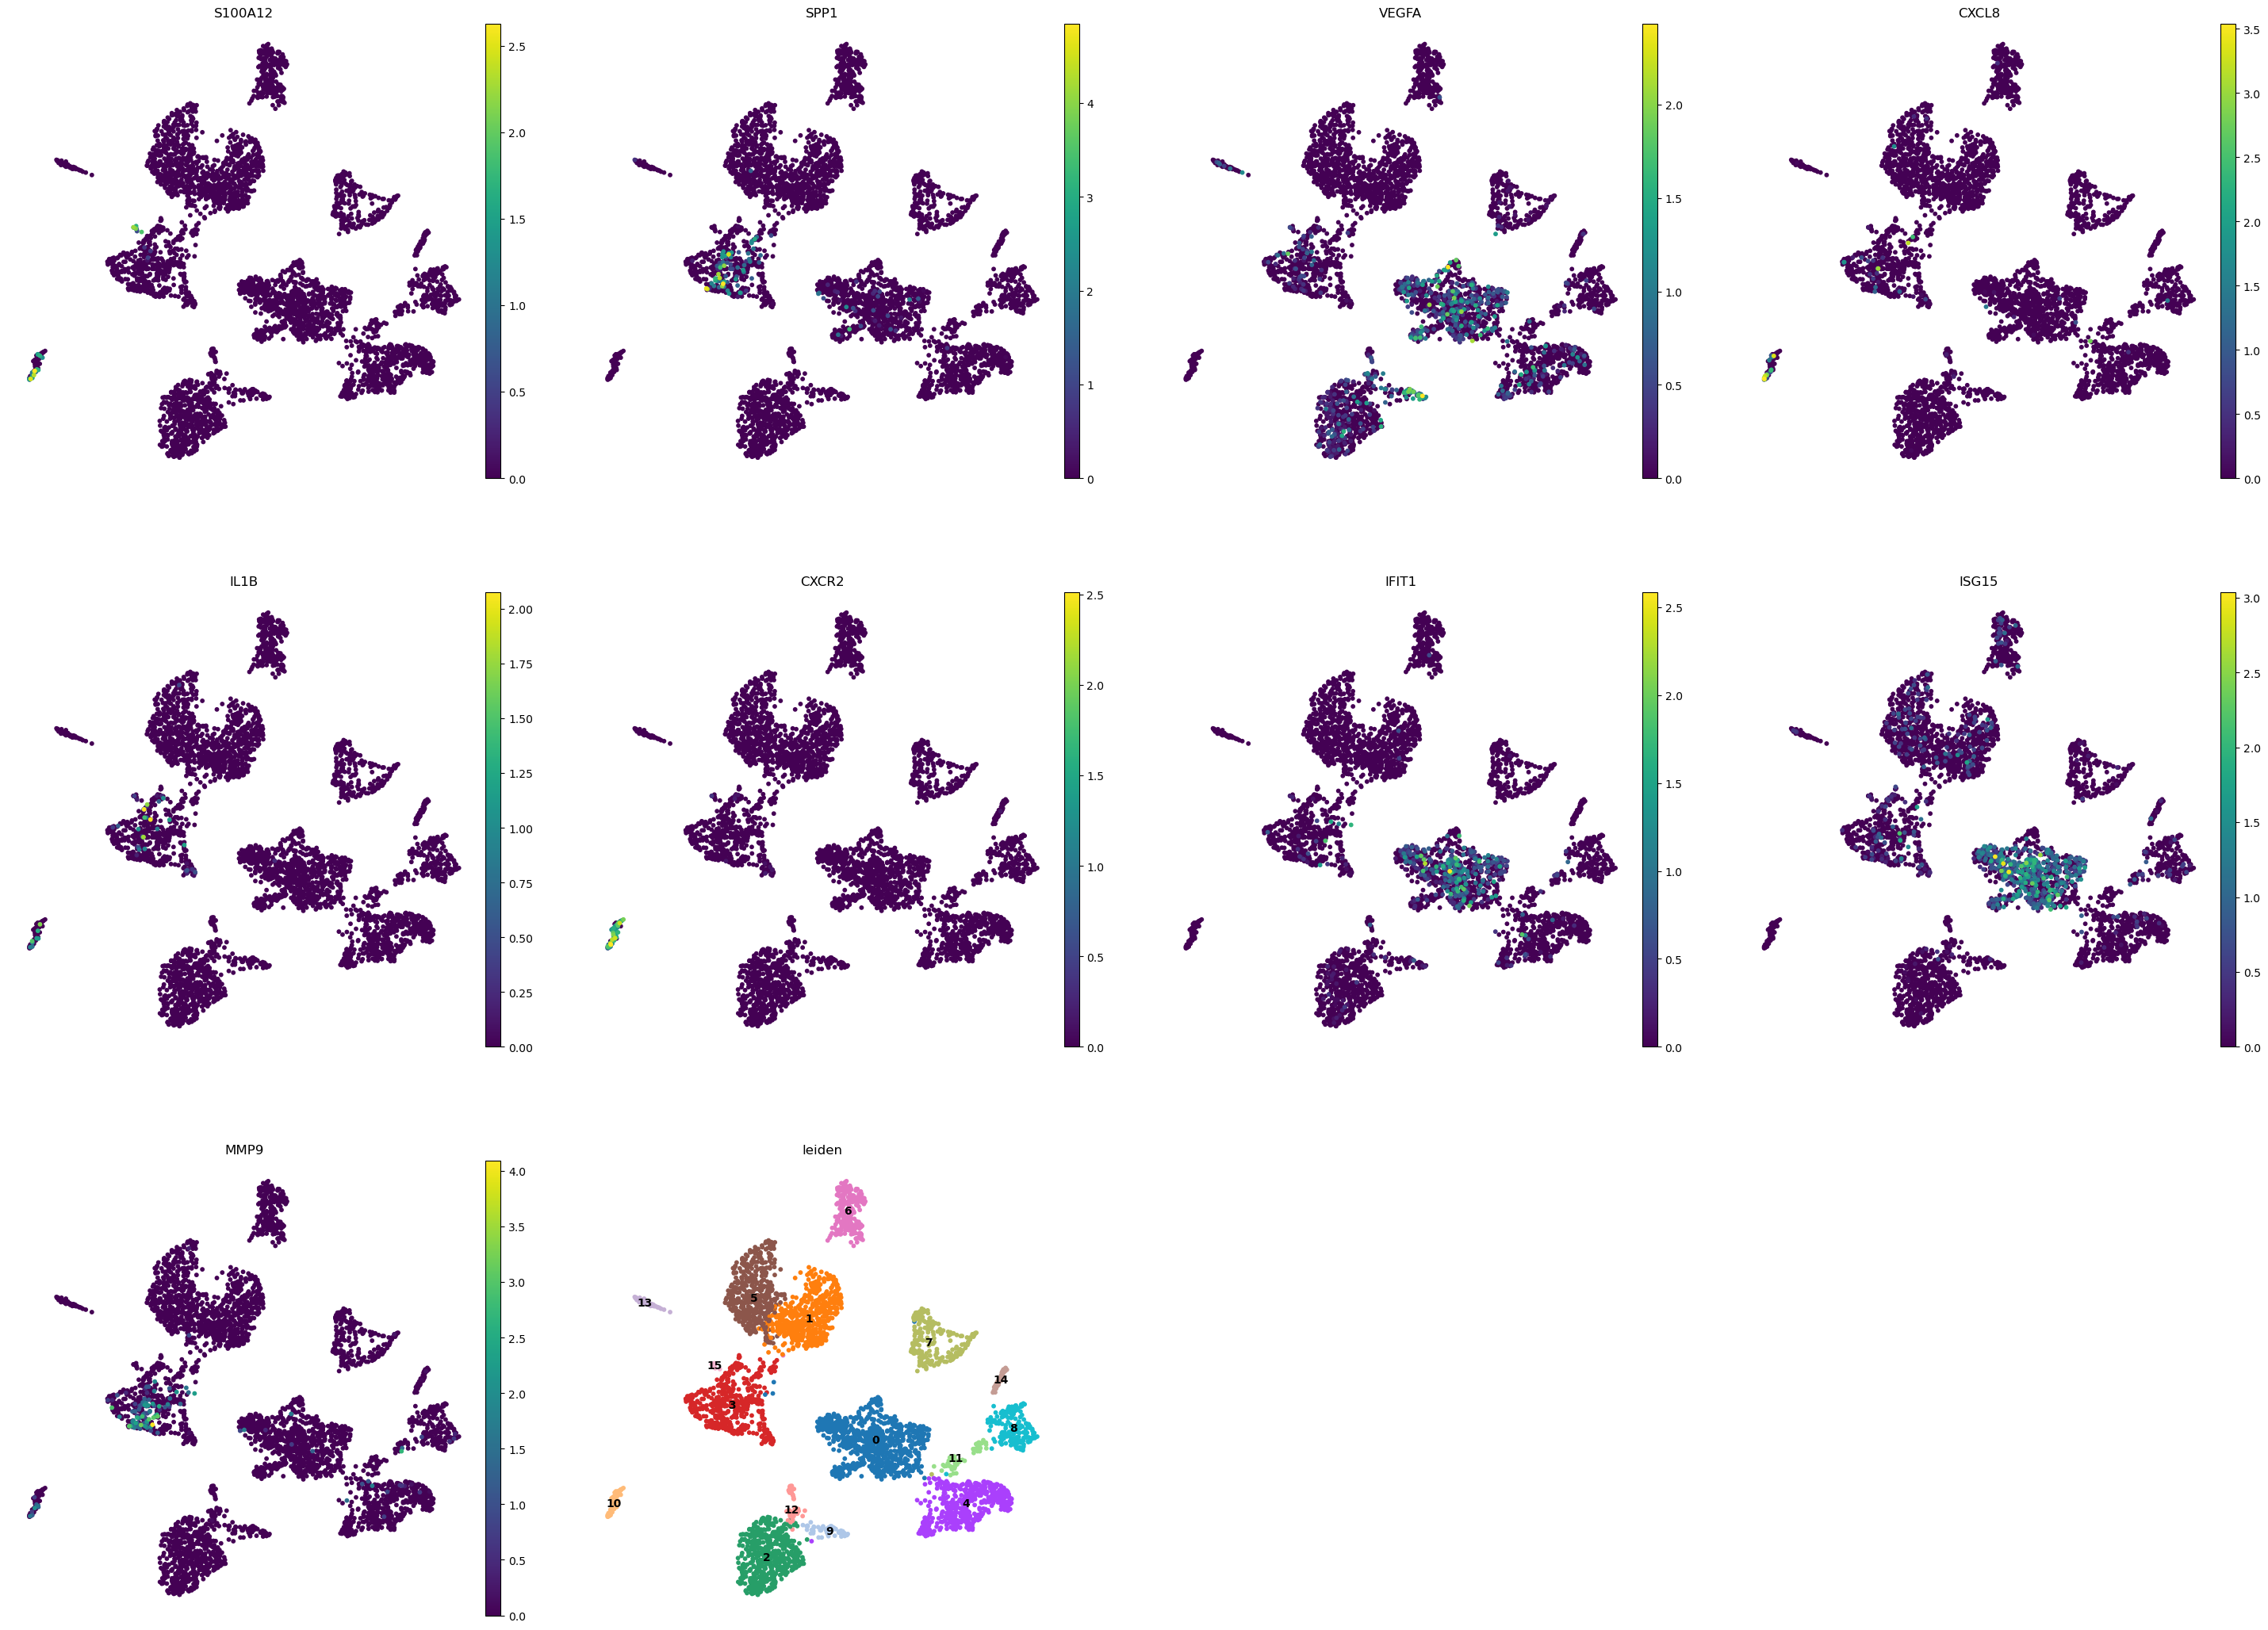

In [7]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_1, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [19]:
markers = {}
for c in adata_1.obs['leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_1, group=c)
    markers[c] = df['names'].tolist()[:5]

In [20]:
markers

{'0': ['CEACAM6', 'KRT8', 'IFI27', 'IFI6', 'CRLF1'],
 '1': ['IL7R', 'CD52', 'TRBC1', 'LTB', 'TRAF1'],
 '2': ['SFTPD', 'SERPINA1', 'ABCA3', 'LAMP3', 'SLPI'],
 '3': ['LYZ', 'IFI30', 'CD68', 'C1QA', 'CTSS'],
 '4': ['COL1A2', 'DCN', 'COL3A1', 'LUM', 'COL1A1'],
 '5': ['CD8A', 'KLRK1', 'GZMA', 'NKG7', 'PRF1'],
 '6': ['MS4A1', 'CD79A', 'BANK1', 'LTB', 'CD79B'],
 '7': ['MZB1', 'DERL3', 'SSR4', 'PIM2', 'JCHAIN'],
 '8': ['PECAM1', 'IGFBP7', 'VWF', 'CD93', 'HSPG2'],
 '9': ['AGER', 'GPRC5A', 'CYP4B1', 'AQP4', 'ATP13A4'],
 '10': ['S100A9', 'S100A8', 'MNDA', 'RGS2', 'SPI1'],
 '11': ['COL6A2', 'COL6A1', 'ACTA2', 'COL4A2', 'MYL9'],
 '12': ['SLPI', 'PIGR', 'ALDH1A1', 'SCGB3A1', 'ELF3'],
 '13': ['CPA3', 'TPSAB1', 'TPSB2', 'KIT', 'MS4A2'],
 '14': ['CCL21', 'FLT4', 'FSCN1', 'PROX1', 'IGFBP7'],
 '15': ['S100A12', 'S100A8', 'PRAM1', 'S100A9', 'CFP']}

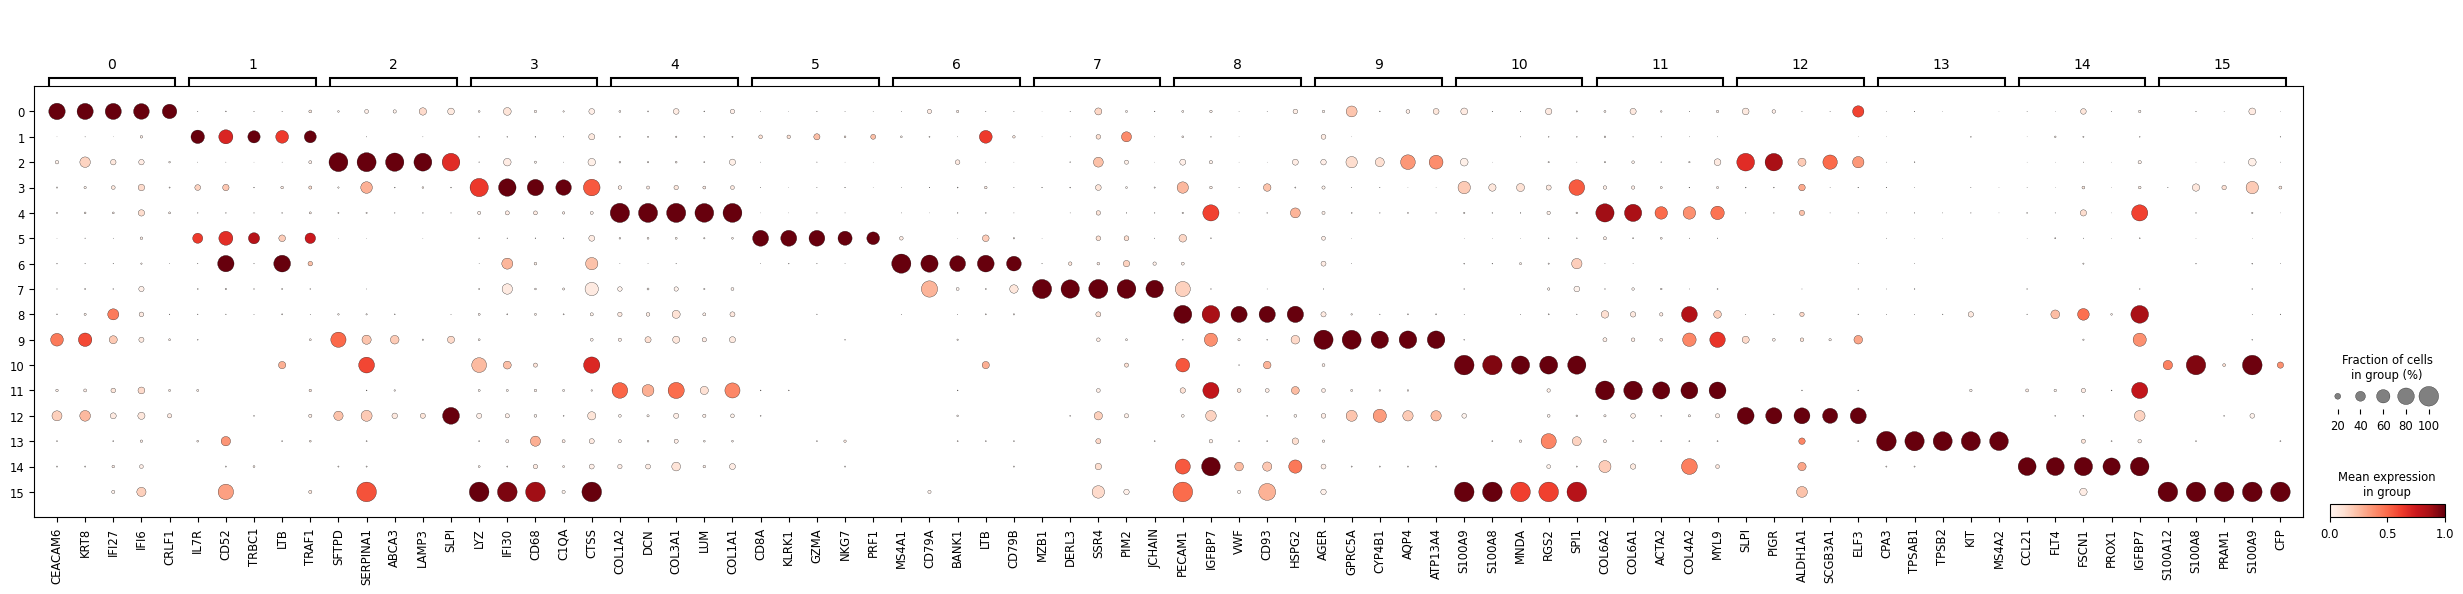

In [21]:
sc.pl.dotplot(adata_1, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [7]:
subset_adata_1 = adata_1[adata_1.obs['leiden'].isin(['10']), :]

In [16]:
sc.pp.neighbors(subset_adata_1, n_pcs=40)
sc.tl.leiden(subset_adata_1, resolution = 1.5)
sc.tl.umap(subset_adata_1)
#sc.write('subset_adata_1.h5ad', subset_adata_1)

In [8]:
#subset_adata_1 = sc.read("subset_adata_1.h5ad")

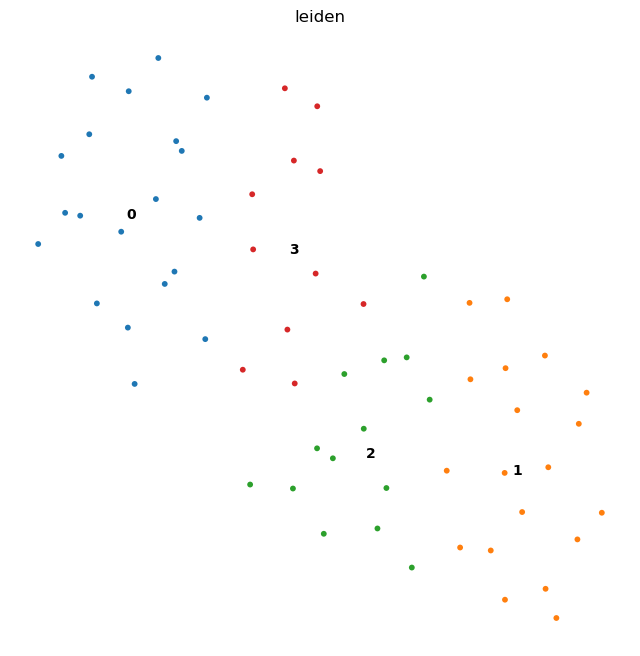

In [17]:
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_adata_1, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

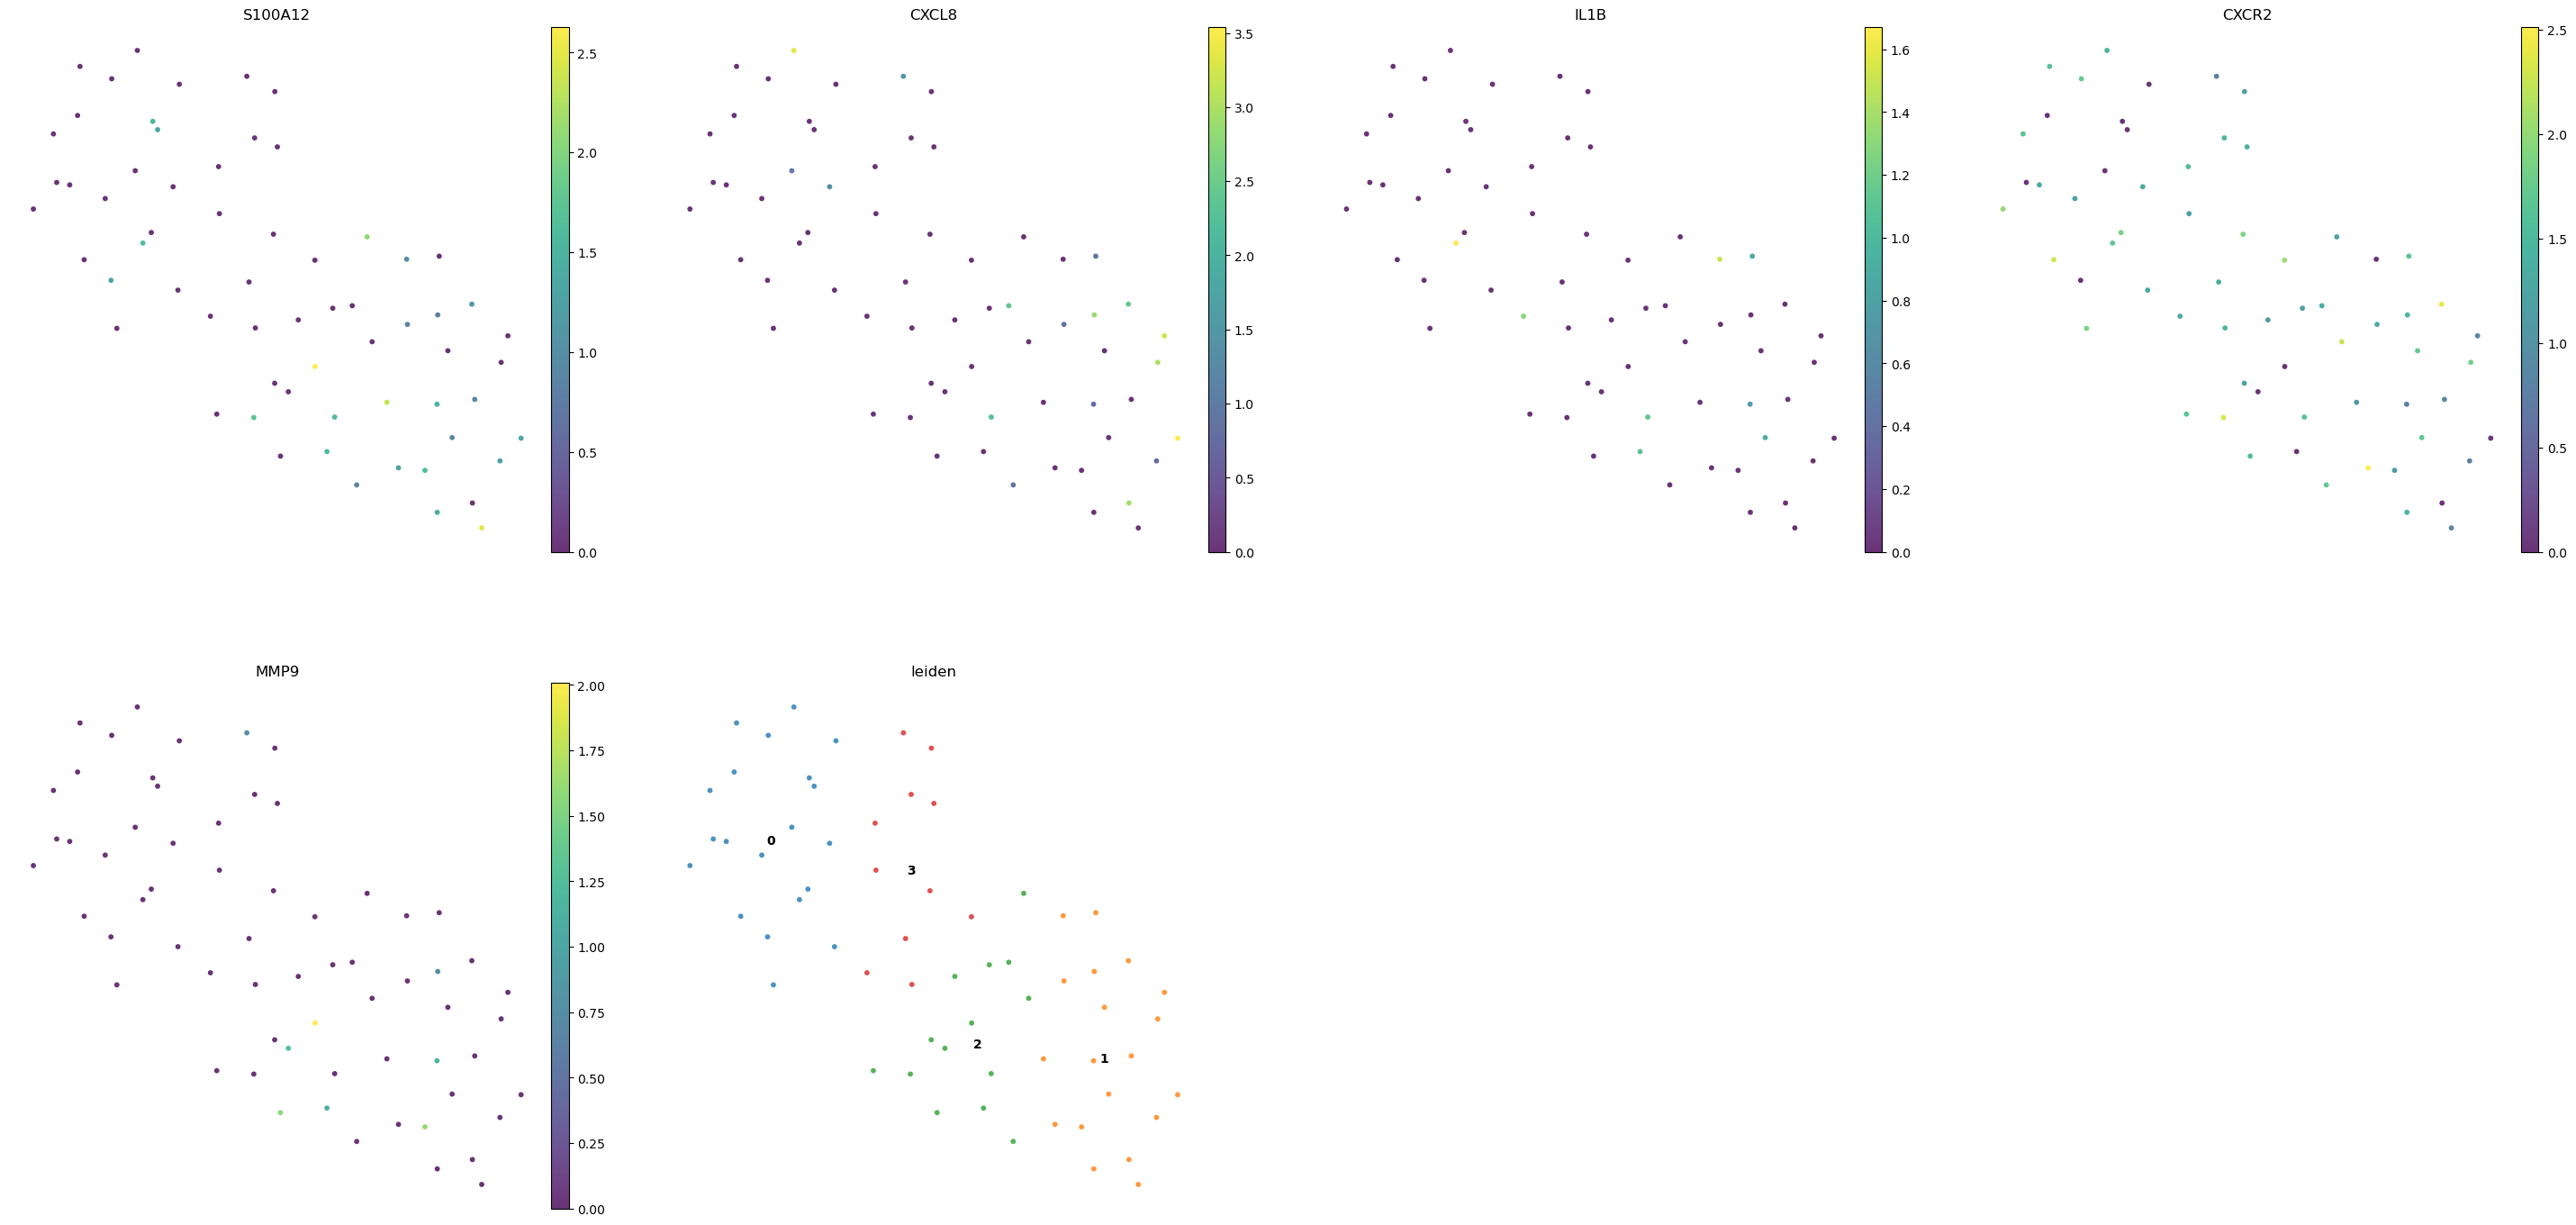

In [18]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_adata_1, color=['S100A12', 'CXCL8', 'IL1B', 'CXCR2', 'MMP9'] + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.8)

In [17]:
subset_adata_1.obs['leiden'] = subset_adata_1.obs['leiden'].astype('category')

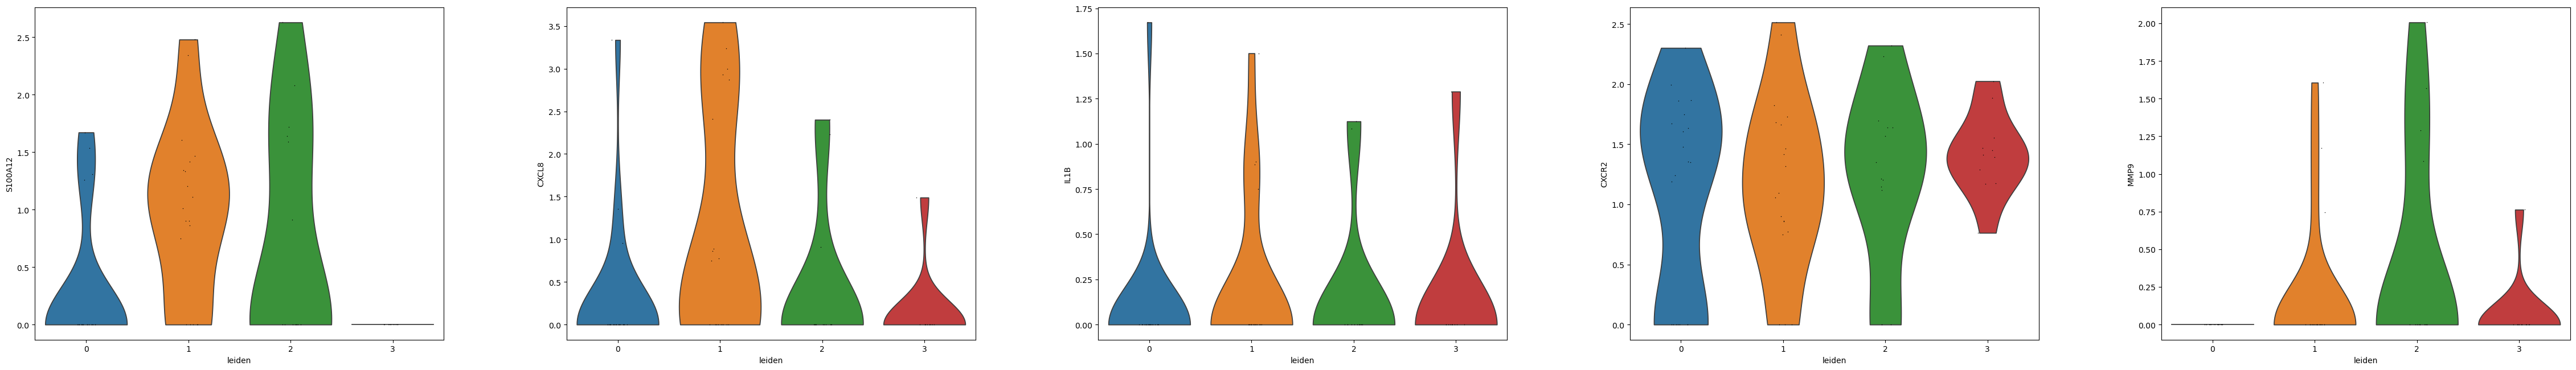

In [19]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.violin(subset_adata_1, ['S100A12', 'CXCL8', 'IL1B', 'CXCR2', 'MMP9'], groupby="leiden")

In [ ]:
#SCVI for clustering

In [12]:
import scvi
def model(adata):
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable] 
    adata = adata.copy()
    scvi.model.SCVI.setup_anndata(adata, layer = "Counts", continuous_covariate_keys=['pct_counts_mt', 'total_counts'])
    vae = scvi.model.SCVI(adata)
    vae.train()
    vae.save(model_path)
    adata.obsm['X_scVI'] = vae.get_latent_representation()
    adata.layers["X_normalized_scVI"] = vae.get_normalized_expression()
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata)
    return adata

In [13]:
scvi_adata_1 = sc.read('/home/mmigl/dom_ameen_chi_link/mmigl/notebooks/adata_1_filtered_new.h5ad')

In [14]:
model_path = 'vae_model_1/'

In [15]:
scvi_adata_1 = model(scvi_adata_1)

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [01:53<00:00,  3.55it/s, v_num=1, train_loss_step=468, train_loss_epoch=408]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [01:53<00:00,  3.52it/s, v_num=1, train_loss_step=468, train_loss_epoch=408]


In [16]:
vae = scvi.model.SCVI.load(model_path, adata=scvi_adata_1)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File vae_model_1/model.pt already downloaded                                                              


In [17]:
sc.tl.leiden(scvi_adata_1, resolution = 0.5)
sc.write('adata_1_scvi_new.h5ad', scvi_adata_1)

In [15]:
scvi_adata_1 = sc.read("/home/mmigl/dom_ameen_chi_link/mmigl/notebooks/adata_1_scvi_new.h5ad")

In [16]:
scvi_adata_1

AnnData object with n_obs × n_vars = 4291 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'connectivities', 'distances'

In [29]:
scvi_adata_1.X = scvi_adata_1.X.toarray()

In [30]:
scvi_adata_1.X

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  4,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

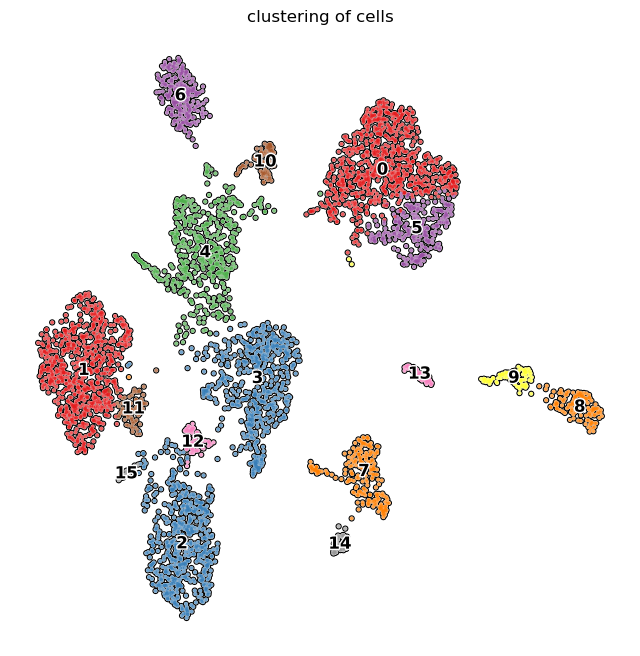

In [16]:
with rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(
        scvi_adata_1,
        color="leiden",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

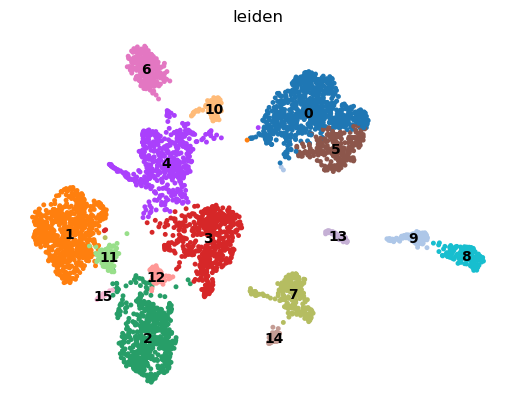

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = 'leiden', s = 50, frameon=False, legend_loc="on data", alpha=1, ax=ax)
fig.savefig('/home/mmigl/clusters_1.png')

In [32]:
original_X = scvi_adata_1.X

In [33]:
original_X

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  4,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [34]:
scvi_adata_1.X = scvi_adata_1.layers['X_normalized_scVI']

In [35]:
scvi_adata_1.X

array([[1.4924964e-05, 1.5406508e-10, 1.9077890e-05, ..., 1.2384121e-03,
        3.0757359e-04, 1.1476959e-06],
       [5.3723743e-05, 1.6581186e-08, 4.4298451e-04, ..., 6.9869682e-05,
        1.9056504e-05, 2.1588403e-06],
       [9.0567570e-05, 7.5718049e-08, 5.1646086e-04, ..., 3.2766932e-04,
        1.0193328e-04, 2.8623222e-06],
       ...,
       [3.7078308e-03, 4.8701841e-06, 3.0873486e-04, ..., 2.5445970e-06,
        4.3061249e-11, 6.9199041e-07],
       [2.5054935e-04, 1.9755660e-07, 5.5920833e-04, ..., 1.1052375e-06,
        1.4548188e-08, 2.6932616e-06],
       [1.1337490e-04, 1.5695761e-07, 2.4788507e-05, ..., 3.1824443e-06,
        3.2425226e-07, 1.7577405e-03]], dtype=float32)

In [36]:
sc.tl.score_genes(scvi_adata_1, ["SPP1", "VEGFA"], score_name="SPP1+VEGFA+", use_raw = False)

In [37]:
sc.tl.score_genes(scvi_adata_1, ["CXCL8", "IL1B"], score_name="CXCL8+IL1B+", use_raw = False)

In [38]:
sc.tl.score_genes(scvi_adata_1, ["IFIT1", "ISG15"], score_name="IFIT1+ISG15+", use_raw = False)

In [39]:
scvi_adata_1.X = original_X

In [40]:
scvi_adata_1.X

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  4,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [41]:
maxabs_1 = max(abs(scvi_adata_1.obs["SPP1+VEGFA+"]))

In [42]:
maxabs_2 = max(abs(scvi_adata_1.obs["CXCL8+IL1B+"]))

In [43]:
maxabs_3 = max(abs(scvi_adata_1.obs["IFIT1+ISG15+"]))

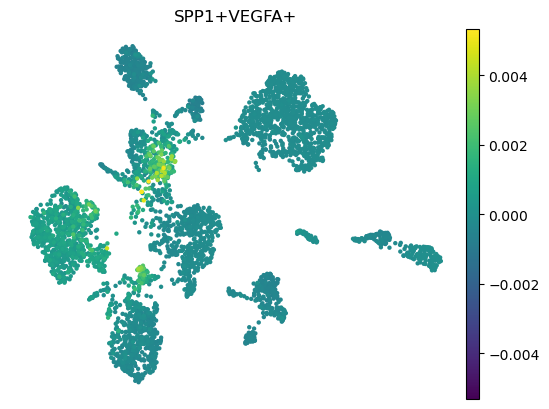

In [46]:
fig, ax = plt.subplots()
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = "SPP1+VEGFA+", s = 40, frameon=False, legend_loc="on data", alpha=1, vmin=-maxabs_1, vmax=maxabs_1, ax=ax)
fig.savefig('/home/mmigl/SPP1+VEGFA+_plot_1.png')

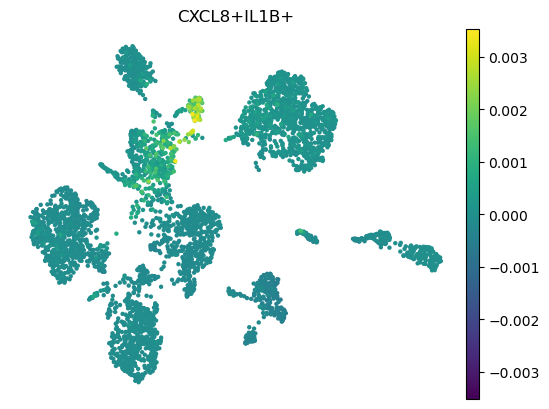

In [47]:
fig, ax = plt.subplots()
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = "CXCL8+IL1B+", s = 40, frameon=False, legend_loc="on data", alpha=1, vmin=-maxabs_2, vmax=maxabs_2, ax=ax)
fig.savefig('/home/mmigl/CXCL8+IL1B+_plot_1.png')

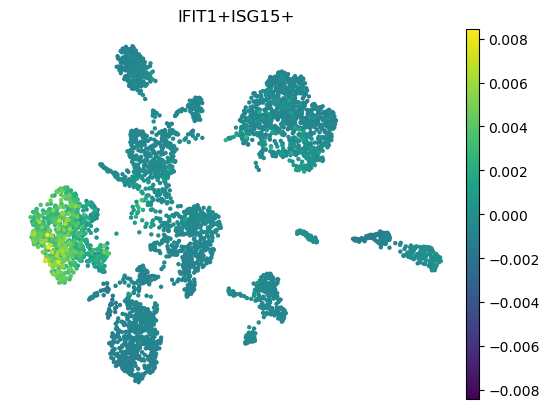

In [48]:
fig, ax = plt.subplots()
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = "IFIT1+ISG15+", s = 40, frameon=False, legend_loc="on data", alpha=1, vmin=-maxabs_3, vmax=maxabs_3, ax=ax)
fig.savefig('/home/mmigl/IFIT1+ISG15+_plot_1.png')

In [50]:
import numpy as np
gene_vmin_vmax = {}
for gene in scvi_adata_1.var_names:
    max_value = np.max(np.abs(scvi_adata_1[:, gene].layers['X_normalized_scVI'].toarray()))
    gene_vmin_vmax[gene] = (-max_value, max_value)

In [51]:
vmin_1, vmax_1 = gene_vmin_vmax["S100A12"]

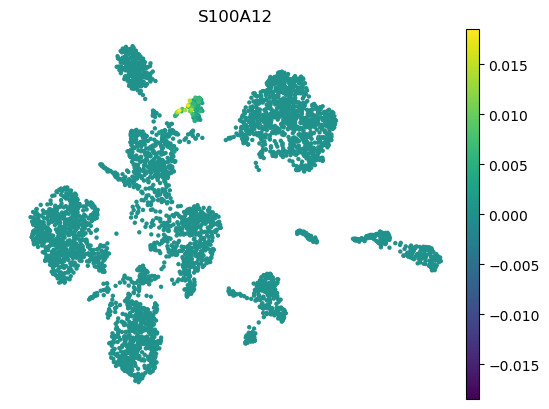

In [53]:
fig, ax = plt.subplots()
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = ["S100A12"], s = 40, frameon=False, legend_loc="on data", alpha=1, vmin=vmin_1, vmax=vmax_1, layer = "X_normalized_scVI", ax=ax)
fig.savefig('/home/mmigl/S100A12+_plot_1.png')

In [54]:
vmin_2, vmax_2 = gene_vmin_vmax["CXCR2"]

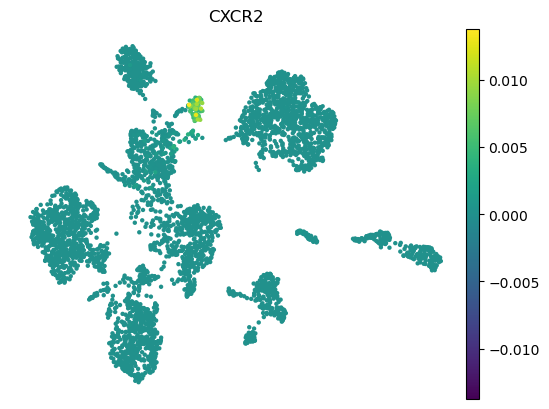

In [55]:
fig, ax = plt.subplots()
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = ["CXCR2"], s = 40, frameon=False, legend_loc="on data", alpha=1, vmin=vmin_2, vmax=vmax_2, layer = "X_normalized_scVI", ax=ax)
fig.savefig('/home/mmigl/CXCR2+_plot_1.png')

In [56]:
vmin_3, vmax_3 = gene_vmin_vmax["MMP9"]

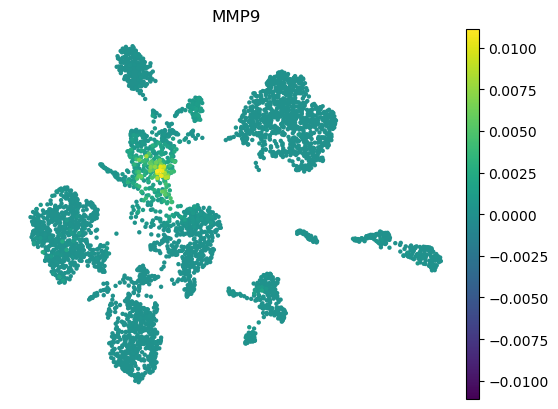

In [58]:
fig, ax = plt.subplots()
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_1, color = ["MMP9"], s = 40, frameon=False, legend_loc="on data", alpha=1, vmin=vmin_3, vmax=vmax_3, layer = "X_normalized_scVI", ax=ax)
fig.savefig('/home/mmigl/MMP9+_plot_1.png')

In [113]:
scvi_df = vae.differential_expression(groupby = 'leiden')

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.07s/it]


In [120]:
#scvi_df.to_csv('scvi_de_results.csv', index=False)

In [117]:
scvi_markers = {}
for c in scvi_adata_1.obs.leiden.cat.categories:
    cell_df = scvi_df.loc[scvi_df.group1 == c]
    scvi_markers[c] = cell_df.index.tolist()[:5]

In [118]:
scvi_markers

{'0': ['TMEM59L', 'RTN4RL2', 'IFI6', 'CEACAM6', 'CEACAM5'],
 '1': ['ABCA3', 'SFRP5', 'AGTR2', 'HHIP', 'PEBP4'],
 '2': ['GZMH', 'NKG7', 'CD8A', 'KLRD1', 'KLRK1'],
 '3': ['C1QB', 'DEPRECATED_ENSG00000150337', 'C1QC', 'FPR3', 'LYZ'],
 '4': ['ADAMTS16', 'COL16A1', 'IGFN1', 'CDH11', 'THBS2'],
 '5': ['FOXP3', 'BPIFA1', 'CD40LG', 'CD8A', 'NKG7'],
 '6': ['BANK1', 'TNFRSF13C', 'AIM2', 'SNX22', 'BCL11A'],
 '7': ['VWF', 'PLVAP', 'PGF', 'FLT1', 'MMRN2'],
 '8': ['IGLC3', 'IGLC2', 'IGHG3', 'TMEM74B', 'DEPRECATED_ENSG00000211890'],
 '9': ['RASSF6', 'PTP4A3', 'SSR4', 'CPEB4', 'HERPUD1'],
 '10': ['S100A8', 'MNDA', 'COL1A2', 'S100A12', 'CXCR2'],
 '11': ['SCEL', 'AGER', 'LAMA3', 'EMP2', 'ANXA3'],
 '12': ['MUC5B', 'SCGB1A1', 'CYP2F1', 'MROH9', 'KLK13'],
 '13': ['CMA1', 'CTSG', 'RHEX', 'SLC8A3', 'CPA3'],
 '14': ['CCL21', 'PHF24', 'SNCB', 'GPR1', 'PROX1']}

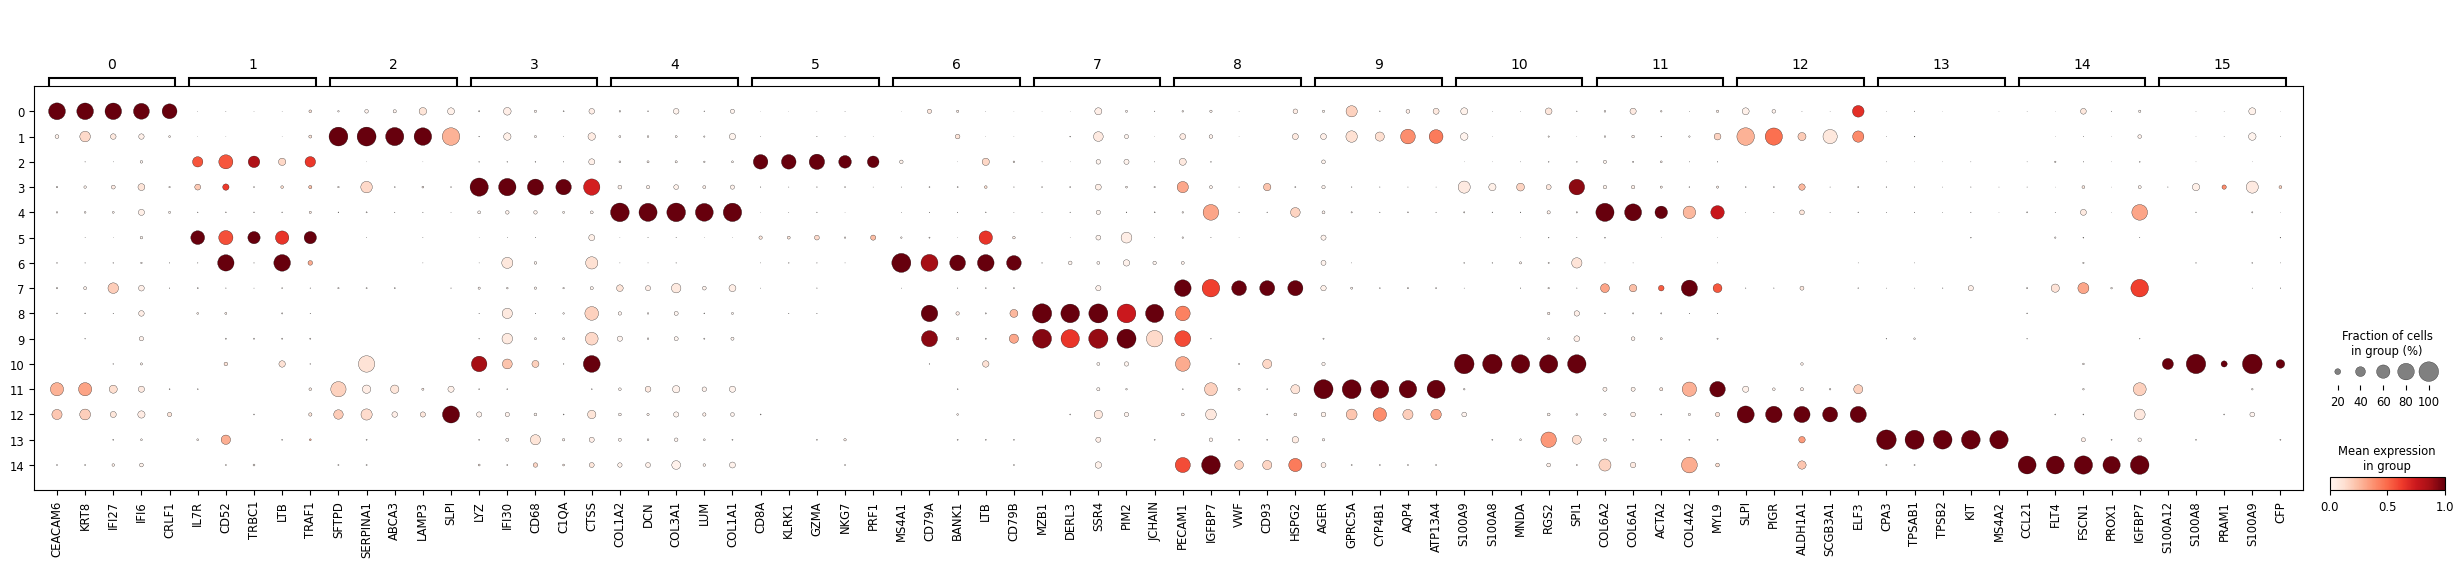

In [119]:
sc.pl.dotplot(scvi_adata_1, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [26]:
subset_scvi_adata_1 = scvi_adata_1[adata_1.obs['leiden'].isin(['10']), :]

In [27]:
subset_scvi_adata_1

View of AnnData object with n_obs × n_vars = 64 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'connectivities', 'distances'

In [28]:
sc.pp.neighbors(subset_scvi_adata_1, use_rep="X_scVI")
sc.tl.umap(subset_scvi_adata_1)
sc.tl.leiden(subset_scvi_adata_1, resolution = 0.5)

In [29]:
#sc.write('subset_scvi_adata_1.h5ad', subset_scvi_adata_1)

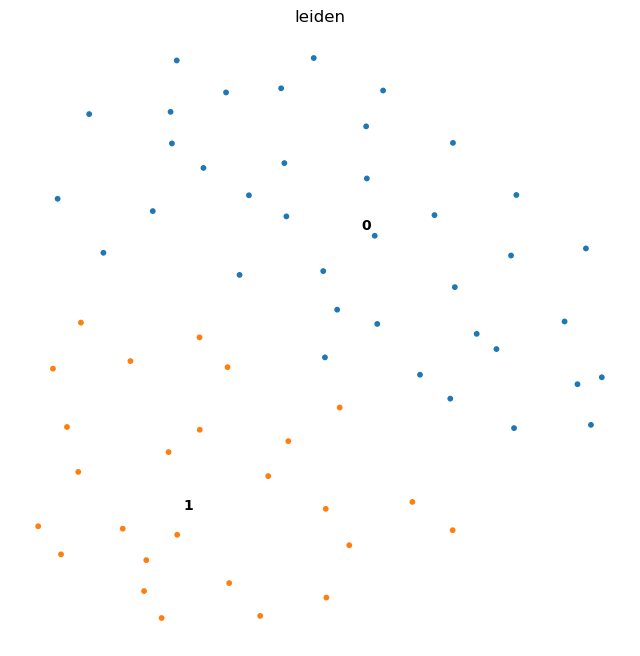

In [30]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_scvi_adata_1, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

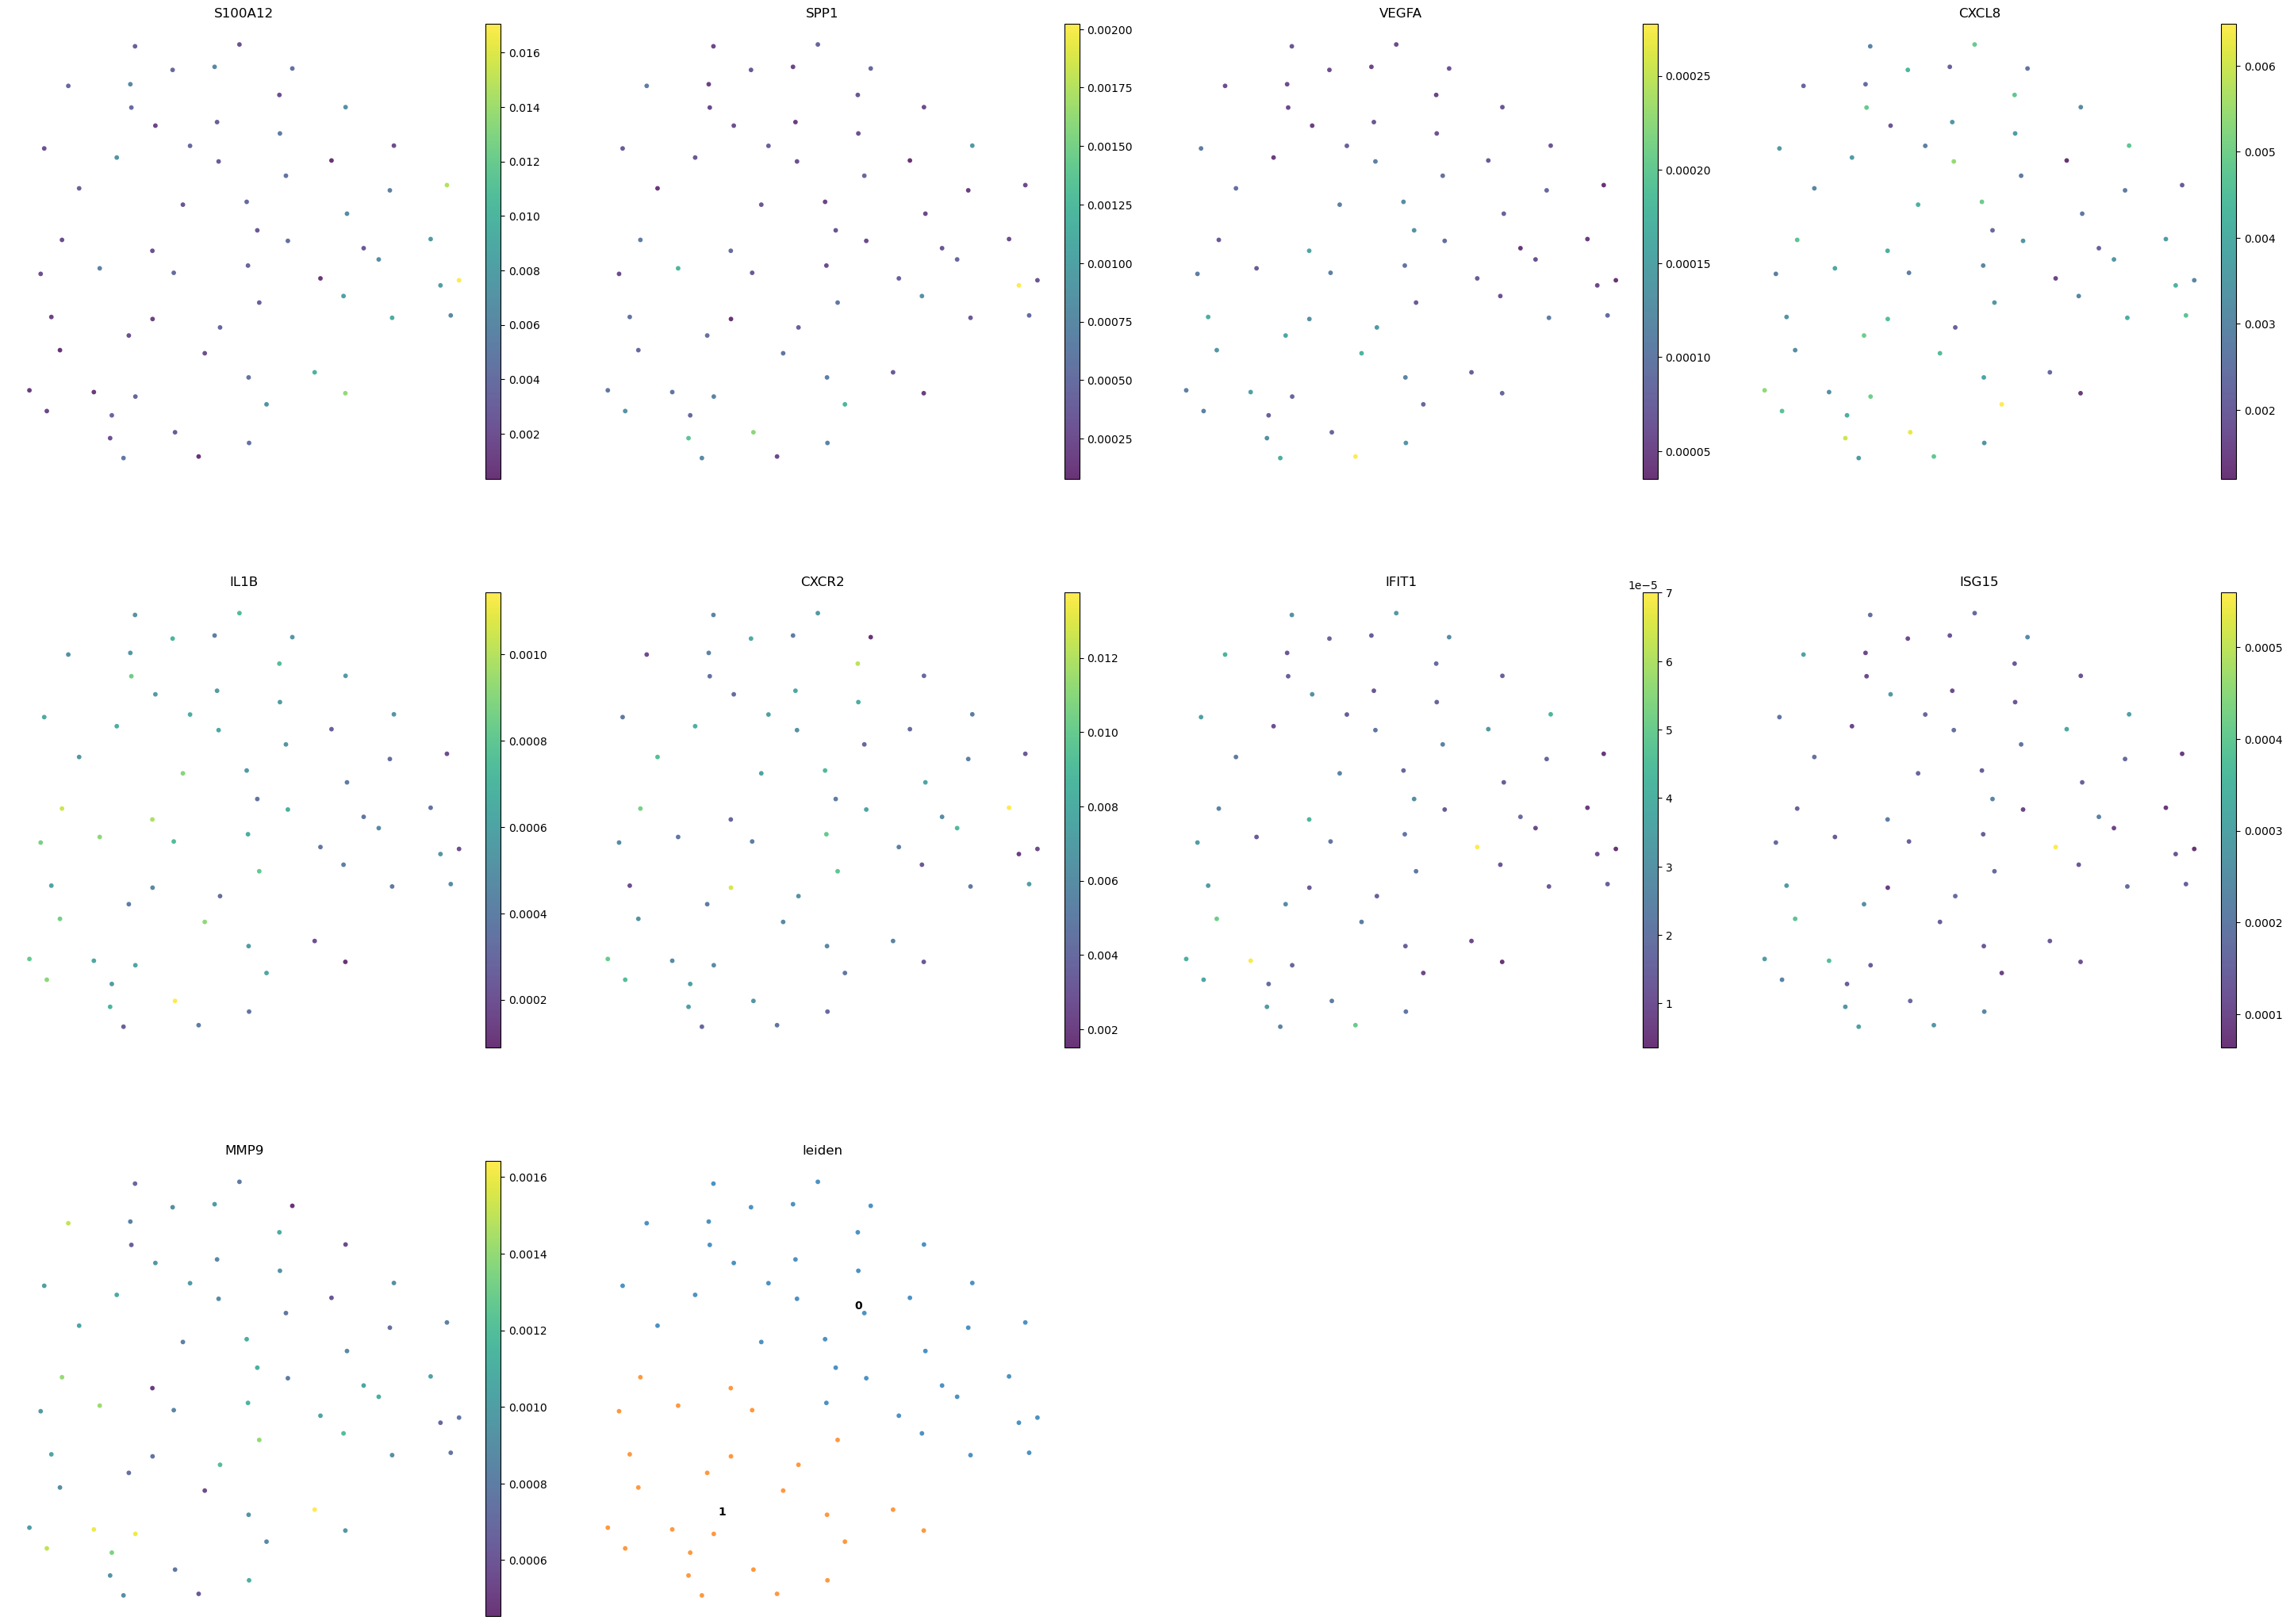

In [31]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_scvi_adata_1, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.8, layer = "X_normalized_scVI")

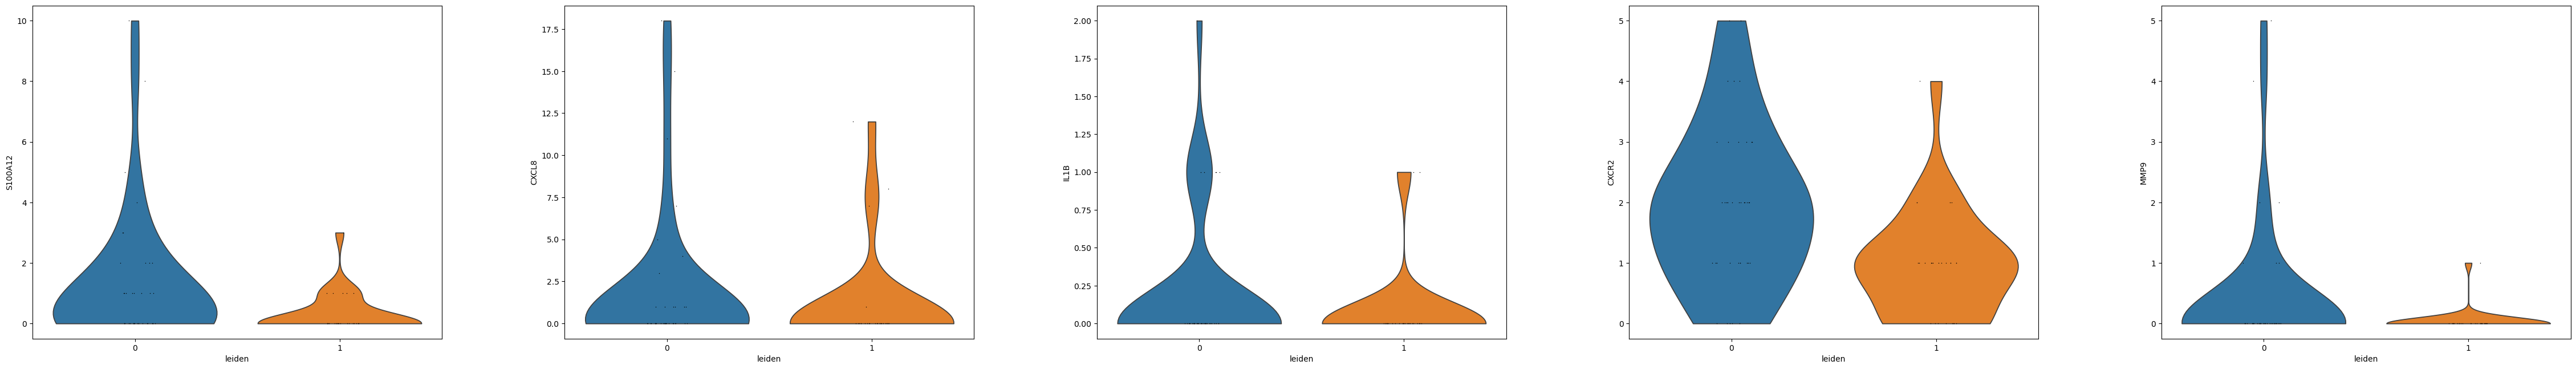

In [32]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.violin(subset_scvi_adata_1, ['S100A12', 'CXCL8', 'IL1B', 'CXCR2', 'MMP9'], groupby="leiden")

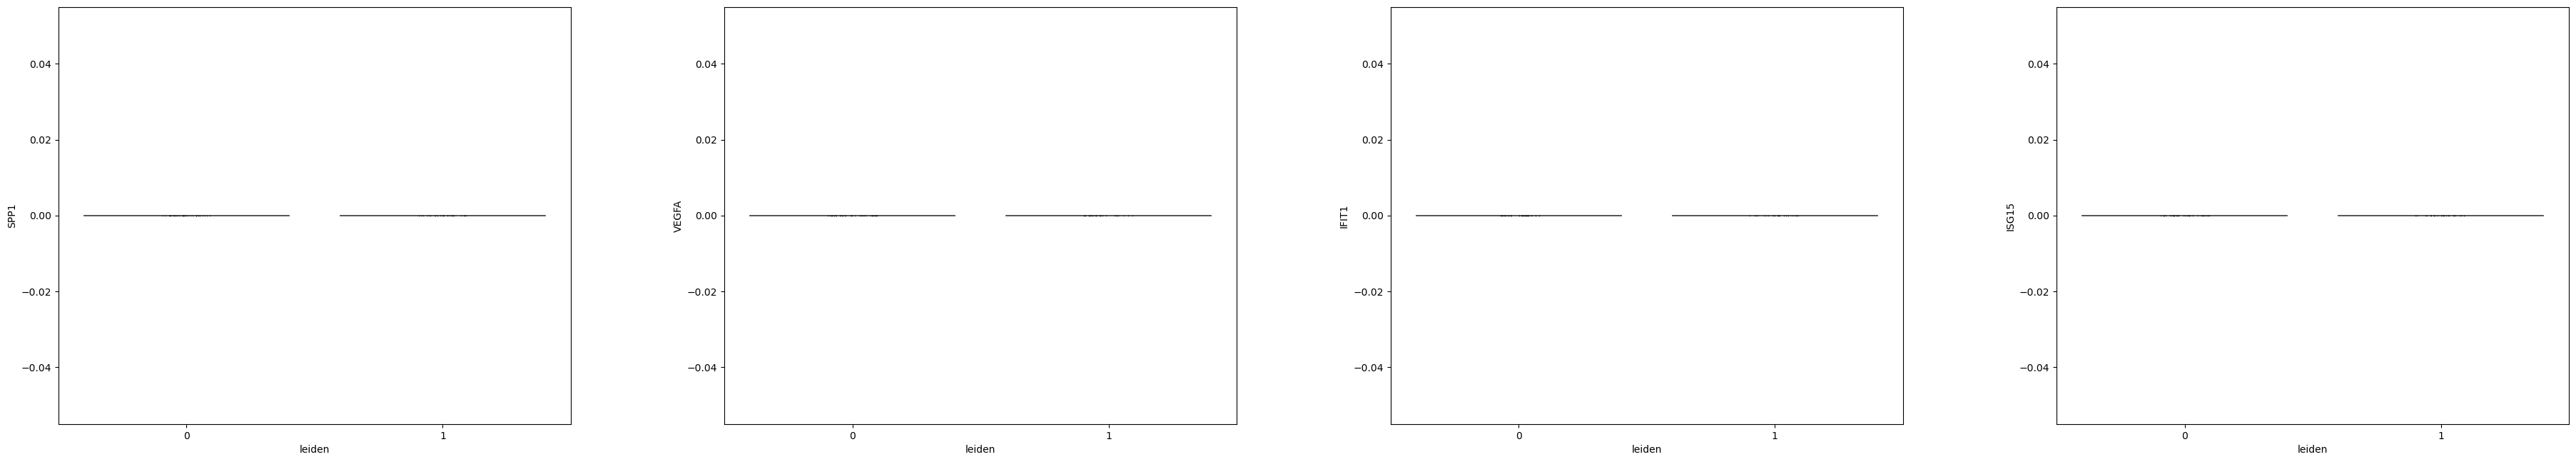

In [34]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.violin(subset_scvi_adata_1, ['SPP1', 'VEGFA', 'IFIT1', 'ISG15'], groupby="leiden")